# LSTM Architecture

We will test various lstm models.


Possible idea: Granger Causality

In [1]:
# Import Necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import mean_squared_error
from math import sqrt
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')

In [2]:
# check to see if GPU is used
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4621281822443714443
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7690417290836264801
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5668667392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14386463127826387254
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13872566340667906184
physical_device_desc: "device: XLA_GPU device"
]


# Assumptions

* All models will use data after 2008-08-30
* All models will test on the year 2008

# Vanilla LSTM 

* Input
* 1 Hidden LSTM layer
* Output

In [3]:
class Vanilla_LSTM():
    """A class for vanilla LSTM
    """
    
    def __init__(self, epochs = 1, lookback = 5, layer_size = 64):
        self.epochs = epochs
        self.lookback = lookback
        self.layer_size = layer_size
        self.train_gen, self.val_gen, self.test_gen = self.preprocess_data()
        self.model = self.build_compile()

        
    def preprocess_data(self):
        """A function to load data
        """
        
        # Load and preprocess data
        data_path = "../data/ucsbdata.csv"
        raw_data = pd.read_csv(data_path)
        # Select subset of data
        market_crash = '2008-08-30'
        data = raw_data.loc[raw_data.Index > market_crash]
        # Convert Int Values to float 
        non_float_columns = ['URR', 'FOMC', 'PPIR', 'HULBERTSENTIMENT', 'TOM']
        for column in non_float_columns:
            data[column] = data[column].astype(float)
        # convert string Index to datatime
        non_datetime_column = 'Index'
        datetime_values = pd.to_datetime(data[non_datetime_column]).values
        data[non_datetime_column] = datetime_values
        # Replace current index with data index 
        data.set_index(non_datetime_column, inplace = True)
        
        # Create test data frame for the year 2018
        test_year = '2018'
        lookback_year = '2017'
        lookback_2017 = data[lookback_year].iloc[-self.lookback:-1].index.min()
        test_df = data.loc[lookback_2017:test_year]
        
        # Create training data frame for 2008 - 2017
        train_df = data.loc[:lookback_year]
        train_df = train_df.iloc[:-self.lookback]
        
        # Create Test Dataset and test labels
        test_label = 'R'
        test_labels = test_df[test_label].values
        test_data = test_df.iloc[:, 1:].values
        
        # Create Training and validation set: Split with 20% Validation set
        train_labels = train_df[test_label].values
        train_features = train_df.iloc[:, 1:].values
        validation_percentage = 0.2
        train_data, val_data, train_labels, val_labels = train_test_split(
            train_features,
            train_labels,
            test_size = validation_percentage,
            random_state = 0,
            shuffle = False)
        
        # Normalize the data for each feature
        sc = StandardScaler()
        train_data = sc.fit_transform(train_data)
        val_data = sc.transform(val_data)
        test_data = sc.transform(test_data)

        # Data Generator for LSTM model
        sampling_rate = 1
        train_batch_size = 14
        val_batch_size = 14
        test_batch_size = 14
        train_generator = TimeseriesGenerator(train_data, train_labels,
                                             length = self.lookback,
                                             batch_size = train_batch_size,
                                             sampling_rate = sampling_rate,
                                             shuffle = False)
        validation_generator = TimeseriesGenerator(val_data, val_labels,
                                                  length = self.lookback,
                                                  batch_size = val_batch_size,
                                                  shuffle = False)
        test_generator = TimeseriesGenerator(test_data, test_labels,
                                            length = self.lookback,
                                            batch_size = test_batch_size,
                                            sampling_rate = sampling_rate,
                                            shuffle = False)    
        # Return the data generators
        return train_generator, validation_generator, test_generator
        
    def build_compile(self):
        
        assert type(self.epochs) == int
        assert type(self.lookback) == int
        assert type(self.layer_size) == int
        
        model = Sequential()
        model.add(LSTM(self.layer_size,
                      activation = 'relu',
                      input_shape = (self.lookback, 66)))
        model.add(Dense(1))
        model.compile(optimizer = 'ADAM', loss = 'mean_absolute_error')
        return model
    
    def fit_evaluate(self):
        self.model.fit(self.train_gen, validation_data = self.val_gen,
               epochs = self.epochs)
        evaluation = self.model.evaluate(self.train_gen)
        return 1 / evaluation
    
    def predictions(self):
        self.model.fit(self.train_gen, validation_data = self.val_gen,
                      epochs = self.epochs)
        vanilla_predictions = self.model.predict(self.test_gen, verbose = 0)
        plt.plot(vanilla_predictions)
        plt.plot(self.test_gen.targets)

In [ ]:
# Function to model
def vanilla_blackbox(epochs = 1, lookback = 5, layer_size = 64):
    epochs = int(epochs)
    lookback = int(lookback)
    layer_size = int(layer_size)
    vanilla_lstm = Vanilla_LSTM(epochs = epochs, lookback = lookback, 
                                layer_size = layer_size)
    vanilla_evaluation = vanilla_lstm.fit_evaluate()
    return vanilla_evaluation

In [ ]:
# Bayes optimization for the parameter epochs
pbounds = {'epochs': (1,100),
          'lookback': (1,14),
          'layer_size': (1,128)}
vanilla_optimizer = BayesianOptimization(f = vanilla_blackbox,
                                        pbounds = pbounds,
                                        verbose = 2,
                                        random_state = 1)

In [ ]:
vanilla_optimizer.maximize(init_points = 10,
                          n_iter = 7)
print(vanilla_optimizer.max)

Train for 134 steps, validate for 34 steps
Epoch 1/87
134/134 [==============================] - 3s 24ms/step - loss: 0.1303 - val_loss: 0.0733
Epoch 2/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0738 - val_loss: 0.0588
Epoch 3/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0473 - val_loss: 0.1157
Epoch 4/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0427 - val_loss: 0.1630
Epoch 5/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0328 - val_loss: 0.1294
Epoch 6/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0715
Epoch 7/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0214 - val_loss: 0.0272
Epoch 8/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0219 - val_loss: 0.0456
Epoch 9/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0167 - val_loss: 0.0247
Epoch 10/87
134/134 [==============================] - 1

Epoch 82/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0042 - val_loss: 0.0059
Epoch 83/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 0.0065
Epoch 84/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 85/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0040 - val_loss: 0.0063
Epoch 86/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0036 - val_loss: 0.0075
Epoch 87/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0038 - val_loss: 0.0063


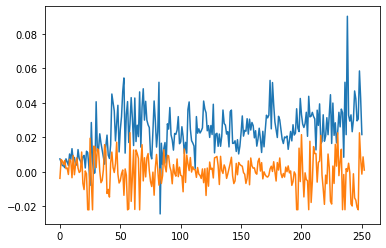

In [4]:
vanilla_lstm_model = Vanilla_LSTM(epochs = 87, lookback = 2, layer_size = 115)
vanilla_lstm_pred = vanilla_lstm_model.predictions()

# Vanilla LSTM with Recurrent dropout

* LSTM Hidden Layer
* Reccurrent dropout in hidden Layers

In [5]:
class Vanilla_RD_LSTM():
    """A class for vanilla LSTM with recurrent dropout
    """
    
    def __init__(self, epochs = 1, lookback = 5, 
                 layer_size = 64, recurrent_dropout = 0.42):
        self.epochs = epochs
        self.lookback = lookback
        self.layer_size = layer_size
        self.recurrent_dropout = recurrent_dropout
        self.train_gen, self.val_gen, self.test_gen = self.preprocess_data()
        self.model = self.build_compile()

        
    def preprocess_data(self):
        """A function to load data
        """
        
        # Load and preprocess data
        data_path = "../data/ucsbdata.csv"
        raw_data = pd.read_csv(data_path)
        # Select subset of data
        market_crash = '2008-08-30'
        data = raw_data.loc[raw_data.Index > market_crash]
        # Convert Int Values to float 
        non_float_columns = ['URR', 'FOMC', 'PPIR', 'HULBERTSENTIMENT', 'TOM']
        for column in non_float_columns:
            data[column] = data[column].astype(float)
        # convert string Index to datatime
        non_datetime_column = 'Index'
        datetime_values = pd.to_datetime(data[non_datetime_column]).values
        data[non_datetime_column] = datetime_values
        # Replace current index with data index 
        data.set_index(non_datetime_column, inplace = True)
        
        # Create test data frame for the year 2018
        test_year = '2018'
        lookback_year = '2017'
        lookback_2017 = data[lookback_year].iloc[-self.lookback:-1].index.min()
        test_df = data.loc[lookback_2017:test_year]
        
        # Create training data frame for 2008 - 2017
        train_df = data.loc[:lookback_year]
        train_df = train_df.iloc[:-self.lookback]
        
        # Create Test Dataset and test labels
        test_label = 'R'
        test_labels = test_df[test_label].values
        test_data = test_df.iloc[:, 1:].values
        
        # Create Training and validation set: Split with 20% Validation set
        train_labels = train_df[test_label].values
        train_features = train_df.iloc[:, 1:].values
        validation_percentage = 0.2
        train_data, val_data, train_labels, val_labels = train_test_split(
            train_features,
            train_labels,
            test_size = validation_percentage,
            random_state = 0,
            shuffle = False)
        
        # Normalize the data for each feature
        sc = StandardScaler()
        train_data = sc.fit_transform(train_data)
        val_data = sc.transform(val_data)
        test_data = sc.transform(test_data)

        # Data Generator for LSTM model
        sampling_rate = 1
        train_batch_size = 14
        val_batch_size = 14
        test_batch_size = 14
        train_generator = TimeseriesGenerator(train_data, train_labels,
                                             length = self.lookback,
                                             batch_size = train_batch_size,
                                             sampling_rate = sampling_rate,
                                             shuffle = False)
        validation_generator = TimeseriesGenerator(val_data, val_labels,
                                                  length = self.lookback,
                                                  batch_size = val_batch_size,
                                                  shuffle = False)
        test_generator = TimeseriesGenerator(test_data, test_labels,
                                            length = self.lookback,
                                            batch_size = test_batch_size,
                                            sampling_rate = sampling_rate,
                                            shuffle = False)    
        # Return the data generators
        return train_generator, validation_generator, test_generator
        
    def build_compile(self):
        
        assert type(self.epochs) == int
        assert type(self.lookback) == int
        assert type(self.layer_size) == int
        
        model = Sequential()
        model.add(LSTM(self.layer_size,
                      activation = 'relu',
                      input_shape = (self.lookback, 66),
                      recurrent_dropout = self.recurrent_dropout))
        model.add(Dense(1))
        model.compile(optimizer = 'ADAM', loss = 'mean_absolute_error')
        return model
    
    def fit_evaluate(self):
        self.model.fit(self.train_gen, validation_data = self.val_gen,
               epochs = self.epochs)
        evaluation = self.model.evaluate(self.train_gen)
        return 1 / evaluation
    
    def predictions(self):
        self.model.fit(self.train_gen, validation_data = self.val_gen,
                      epochs = self.epochs)
        vanilla_rd_predictions = self.model.predict(self.test_gen, verbose = 0)
        plt.plot(vanilla_rd_predictions)
        plt.plot(self.test_gen.targets)

In [ ]:
# Black box model
def vanilla_rd_blackbox(epochs = 1, lookback = 5, 
                        layer_size = 64, recurrent_dropout = 0.42):
    epochs = int(epochs)
    lookback = int(lookback)
    layer_size = int(layer_size)
    vanilla_rd_lstm = Vanilla_RD_LSTM(epochs = epochs, lookback = lookback, 
                                layer_size = layer_size,
                               recurrent_dropout = recurrent_dropout)
    vanilla_rd_evaluation = vanilla_rd_lstm.fit_evaluate()
    return vanilla_rd_evaluation

In [ ]:
# Bayes optimization for the parameter epochs
pbounds = {'epochs': (1,100),
          'lookback': (1,14),
          'layer_size': (1,128),
          'recurrent_dropout': (0,0.5)}
vanilla_rd_optimizer = BayesianOptimization(f = vanilla_rd_blackbox,
                                        pbounds = pbounds,
                                        verbose = 2,
                                        random_state = 1)

In [ ]:
vanilla_rd_optimizer.maximize(init_points = 10,
                          n_iter = 7)
print(vanilla_rd_optimizer.max)

Train for 134 steps, validate for 34 steps
Epoch 1/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0064
Epoch 2/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 3/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0031 - val_loss: 0.0060
Epoch 4/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 0.0069
Epoch 5/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0034 - val_loss: 0.0064
Epoch 6/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 7/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0061
Epoch 8/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 9/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0060
Epoch 10/87
134/134 [==============================] - 1s

Epoch 82/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0024 - val_loss: 0.0060
Epoch 83/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 84/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0059
Epoch 85/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 86/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0024 - val_loss: 0.0059
Epoch 87/87
134/134 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0058


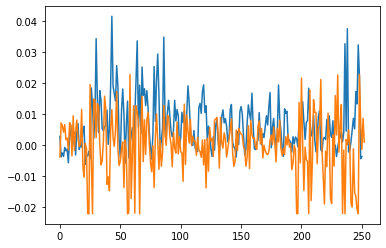

In [6]:
vanilla_rd_lstm_model = Vanilla_RD_LSTM(epochs = 87, lookback = 2, 
                                     layer_size = 115,
                                     recurrent_dropout = 0.0195)
vanilla_rd_lstm_pred = vanilla_lstm_model.predictions()